In [1]:
import pandas_datareader as pdr
import pandas as pd

In [2]:
def get_data():
    temp = pdr.get_data_yahoo('INFY')
    temp.to_csv('infosys.csv')
    return True
get_data() #To work with data extracted.

True

# EDA

In [6]:
df = pd.read_csv('infosys.csv')
df.index = pd.to_datetime(df['Date'], format = "%Y.%m.%d")
df.drop(columns='Date', inplace=True)
print(df.head())

             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2017-07-07  7.540  7.420  7.475  7.520   8271000.0   6.565680
2017-07-10  7.775  7.630  7.735  7.660  14222600.0   6.687913
2017-07-11  7.740  7.635  7.710  7.735  10745200.0   6.753396
2017-07-12  7.830  7.710  7.750  7.820  21274600.0   6.827609
2017-07-13  7.825  7.735  7.775  7.780  20329000.0   6.792685


In [7]:
print(df.tail())

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2022-06-29  18.670000  18.280001  18.370001  18.610001   5126600.0  18.610001
2022-06-30  18.570000  18.340000  18.400000  18.510000  10376700.0  18.510000
2022-07-01  18.910000  18.500000  18.600000  18.850000   9066900.0  18.850000
2022-07-05  18.690001  18.360001  18.510000  18.670000  10265200.0  18.670000
2022-07-06  19.020000  18.700001  18.700001  18.930000   8860200.0  18.930000


In [5]:
print(df.describe())

              High          Low         Open        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean     13.570405    13.340974    13.454932    13.458517  1.047381e+07   
std       5.508405     5.420253     5.465365     5.466926  6.563781e+06   
min       7.155000     6.760000     6.920000     6.940000  1.320600e+06   
25%       9.370000     9.160000     9.246250     9.250000  6.531225e+06   
50%      10.855000    10.705000    10.790000    10.765000  8.877450e+06   
75%      18.467499    18.150000    18.297500    18.290001  1.251438e+07   
max      26.389999    25.580000    26.150000    26.200001  7.716540e+07   

         Adj Close  
count  1258.000000  
mean     12.825092  
std       5.664665  
min       6.225172  
25%       8.559495  
50%       9.995666  
75%      17.845763  
max      25.910423  


In [8]:
print(df.isnull().any(axis=0))  #No null values.

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool


<AxesSubplot:>

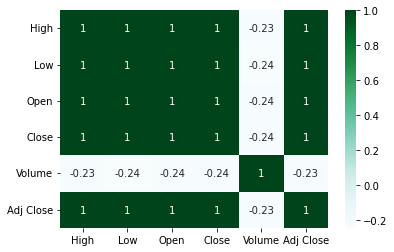

In [9]:
import seaborn as sns
sns.heatmap(df.corr(), cmap = 'BuGn', annot=True)

In [10]:
#We can drop volume column as it has no effect based on the correlation plot.
df.drop(columns='Volume', inplace=True)

In [11]:
df.head()

,High,Low,Open,Close,Adj Close
Date,,,,,
2017-07-07,7.540,7.420,7.475,7.520,6.565680
2017-07-10,7.775,7.630,7.735,7.660,6.687913
2017-07-11,7.740,7.635,7.710,7.735,6.753396
2017-07-12,7.830,7.710,7.750,7.820,6.827609
2017-07-13,7.825,7.735,7.775,7.780,6.792685


# Data-Preprocessing

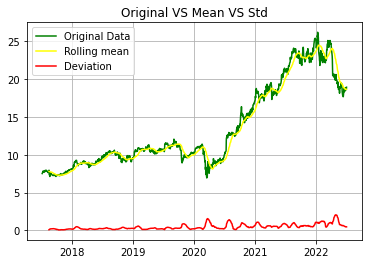

In [72]:
#Getting the moving average and deviation.
data_mean = df['Close'].rolling(window=30).mean()
data_std = df['Close'].rolling(window=30).std()

#Plotting the results.
from matplotlib import pyplot as plt
plt.plot(df['Close'], color='green', label='Original Data')
plt.plot(data_mean, color="yellow", label="Rolling mean")
plt.plot(data_std, color='red', label='Deviation')
plt.legend(loc='best')
plt.title('Original VS Mean VS Std')
plt.grid(True)
plt.show()

In [73]:
#Testing for stationarity of the data.
from statsmodels.tsa.stattools import adfuller

def stationaryTest(timeseries):
    adf = adfuller(timeseries.dropna().values, autolag='AIC')
    output = pd.Series(adf[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adf[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    return True

In [74]:
stationaryTest(df['Close']) #We cannot ignore the null hypothesis and the test statistic is nowhere close to the critical value. We need to remove trend and seaonality of the data.

Test Statistics                  -0.889787
p-value                           0.791317
No. of lags used                  2.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


True

In [75]:
#Making the data stationary.
import numpy as np

def stationaryData(timeseries, windowSize):
    #Removing trends.
    timeseries_log = pd.DataFrame(timeseries['Close'].apply(lambda x: np.log(x)))
    rolling_mean = timeseries_log.rolling(windowSize).mean()
    timeseries_detrended = timeseries_log['Close'] - rolling_mean['Close']

    #Removing seasonality.
    clean_data = timeseries_detrended - timeseries_detrended.shift()
    return clean_data

data = stationaryData(df, 30)

In [76]:
data.dropna(inplace=True)

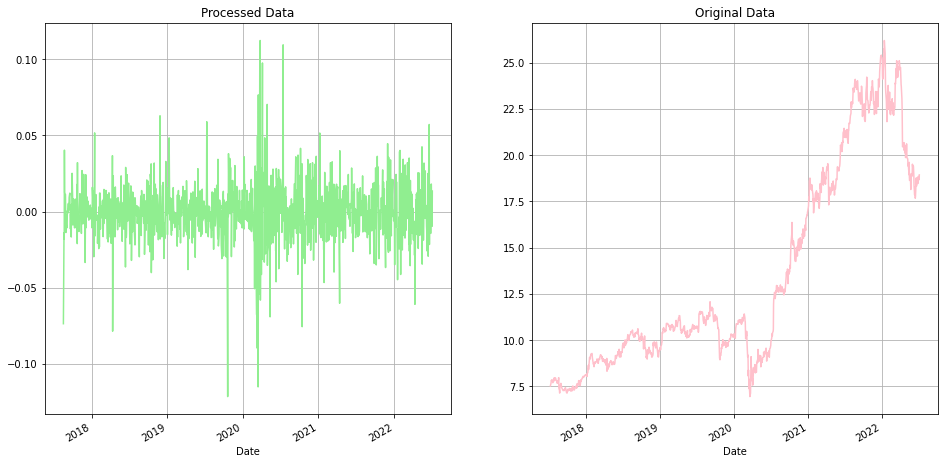

In [77]:
ax1 = plt.subplot(121)
data.plot(figsize=(16,8), color='lightgreen', title='Processed Data', ax = ax1)
plt.grid(True)
ax2 = plt.subplot(122)
df['Close'].plot(figsize=(16,8), color='pink', title='Original Data', ax = ax2)
plt.grid(True)

In [78]:
#We can see that the data has become stationary. 
#Running adfuller test again to confirm the stationarity of the data.
stationaryTest(data) 
#Data is staionary and now we can build our model.

Test Statistics               -1.048600e+01
p-value                        1.179954e-18
No. of lags used               1.200000e+01
Number of observations used    1.215000e+03
critical value (1%)           -3.435744e+00
critical value (5%)           -2.863922e+00
critical value (10%)          -2.568038e+00
dtype: float64


True

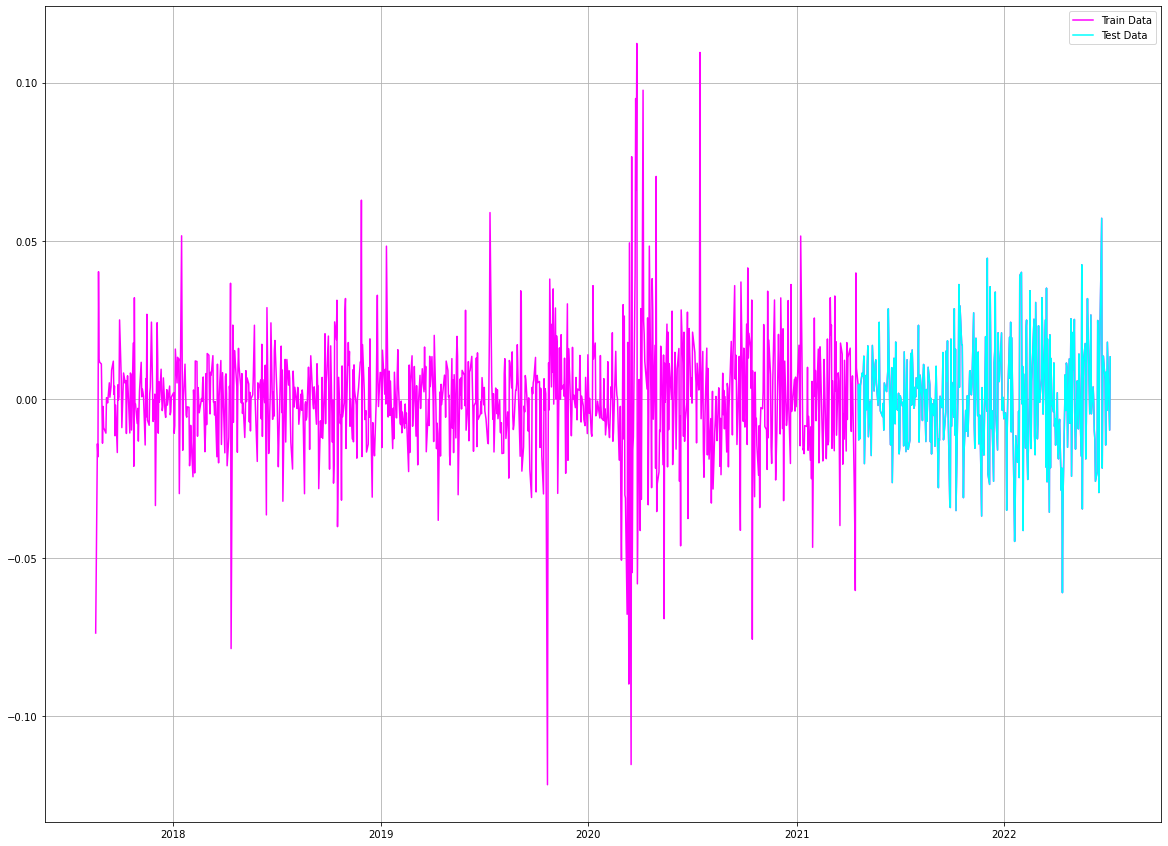

In [79]:
def splitData(timeseries, train_split):
    x_data,y_data = timeseries[:int(len(timeseries)*train_split)], timeseries[int(len(timeseries)*train_split):]
    plt.figure(figsize=(20,15))
    plt.plot(timeseries, color='magenta', label='Train Data')
    plt.plot(y_data, color='cyan', label='Test Data')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()
    return x_data,y_data
train_data,test_data = splitData(data, 0.75)

# Model Building

In [82]:
from pmdarima.arima import auto_arima

#Building the model.
model_values = auto_arima(train_data, start_p=0, start_q=0,max_p=3,max_q=3,test='adf', seasonal=False, stepwise=True, trace=True)
print(model_values.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4662.983, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4666.859, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4665.778, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4674.956, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4673.410, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4672.840, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4667.829, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4671.479, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4672.977, Time=0.51 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 1.890 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  921
Model:               SARIMAX(2, 0, 0)   Log Likelihood                2340.478
Date:                Thu, 07 Jul 2022   

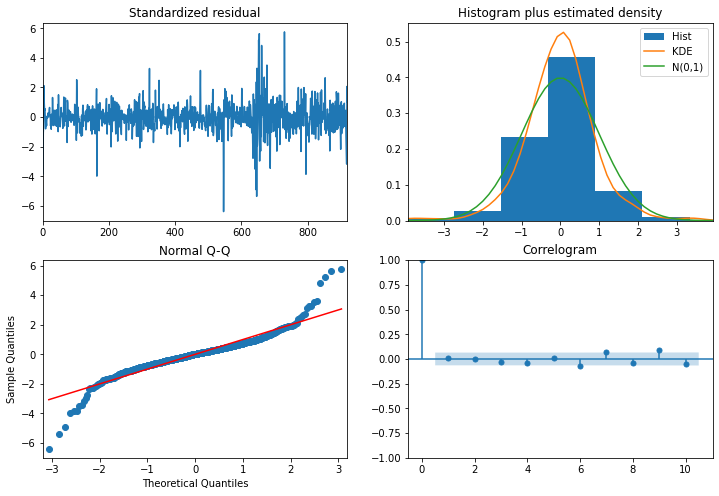

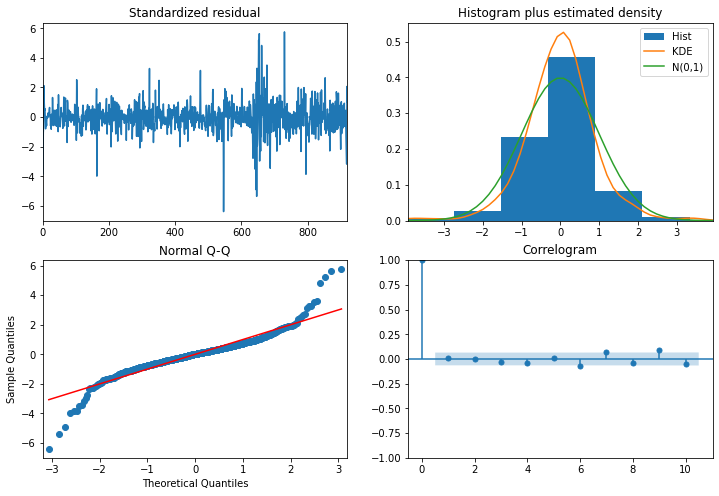

In [81]:
model_values.plot_diagnostics(figsize=(12,8))

In [87]:
#We got the following output from the auto arima model:- Best model:  ARIMA(2,0,0)(0,0,0)[0]
#Using the p,d,q values from this.
import statsmodels
model = statsmodels.api.tsa.ARIMA(train_data,order=(2,0,0))
modelFit = model.fit()
print(modelFit.summary())

C:\Users\neela\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  921
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2340.482
Date:                Thu, 07 Jul 2022   AIC                          -4672.963
Time:                        13:42:47   BIC                          -4653.662
Sample:                             0   HQIC                         -4665.598
                                - 921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -5.81e-05      0.001     -0.089      0.929      -0.001       0.001
ar.L1         -0.0750      0.018     -4.150      0.000      -0.110      -0.040
ar.L2          0.1040      0.021      4.981      0.0